# 2D prescribed flow with time-dependent aerosol injection

Author: Jatan Buch (v1, 240703) || (v2, 240916)

In [1]:
# PySDM libraries
from PySDM_examples.Szumowski_et_al_1998 import Storage
from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal

from open_atmos_jupyter_utils import TemporaryFile
from PySDM_examples.utils import DummyController
from PySDM.exporters import NetCDFExporter

# mod case files
from case_files.settings_2d import Settings
from case_files.spin_up_2d import SpinUp
from case_files.simulation_sd_update_2d import Simulation

import numpy as np
import xarray
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from utils.plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

sav_file_path= "/Users/hyfives-lamont/Desktop/cloud_seeding/sav_files/time_dep_seeding/run_2D_output_files/"
sav_plt_path= "/Users/hyfives-lamont/Desktop/cloud_seeding/plots/time_dep_seeding/run_2D_plots/"

## Case setup

In [2]:
common_params= {
    "n_sd_per_mode": (32,),
    "aerosol_modes_by_kappa": {
        0.54: Lognormal(
            norm_factor=10 / si.cm ** 3,
            m_mode=1E2 * si.nm,
            s_geom=1.4,
        ),
        # .85: Lognormal(
        #     norm_factor= 0.1 / si.cm ** 3,
        #     m_mode= 1 * si.um,
        #     s_geom=1.4
        # ),
    },
    "z_part": ((0., 1), (0., 1.)),
    "x_part": ((0., 1), (0., 1.)),
    "grid": (25, 25),
    "size": (1500 * si.metres, 1500 * si.metres),
    "simulation_time": 5400 * si.second,
    "dt": 5*si.second,
    "spin_up_time": 1800 * si.second,
    "r_seed": 1*si.um,
    "kappa_seed": 0.85,
    #"int_inj_rate": 1E5 / si.cm ** 3,
    #"seed_z_step": [(0., 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.)], #(0.75, 1.),
    #"seed_x_step": [(0., 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.)], #(0.75, 1.),
    "seed_t_step": [], #60,
}

In [3]:
np.random.seed(123)

# settings_ = Settings(
#     Formulae(seed= np.random.randint(1000)),
#     **common_params,
#     )
# seed_t_step_arr= [50, 100, 150, 200]
# seed_output_t_step_arr= settings_.output_steps[[np.argmin(abs(settings_.output_steps - ss)) for ss in seed_t_step_arr]]

settings = Settings(
    Formulae(seed= np.random.randint(1000), terminal_velocity= 'PowerSeries'), 
    **common_params,
    #seed_t_step= seed_output_t_step_arr,
    )
storage = Storage()
simulation = Simulation(settings, storage, SpinUp= None)
simulation.reinit()

/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


In [4]:
simulation.stepwise_sd_update(spup_flag= True)  #seeding_type= 'aggregate',

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [5]:
exporter = NetCDFExporter(storage, settings, simulation, sav_file_path + "_n1_10_r1_0.1_benchmark_tps.nc")
exporter.run(controller=DummyController())

In [6]:
output= xarray.open_dataset(sav_file_path + "_n1_10_r1_0.1_benchmark_tps.nc")
output= output.transpose("T", "Z", "X", "Particles Wet Size Spectrum_bin_left_edges", "Particles Dry Size Spectrum_bin_left_edges", 'radius binned number averaged terminal velocity_bin_left_edges')

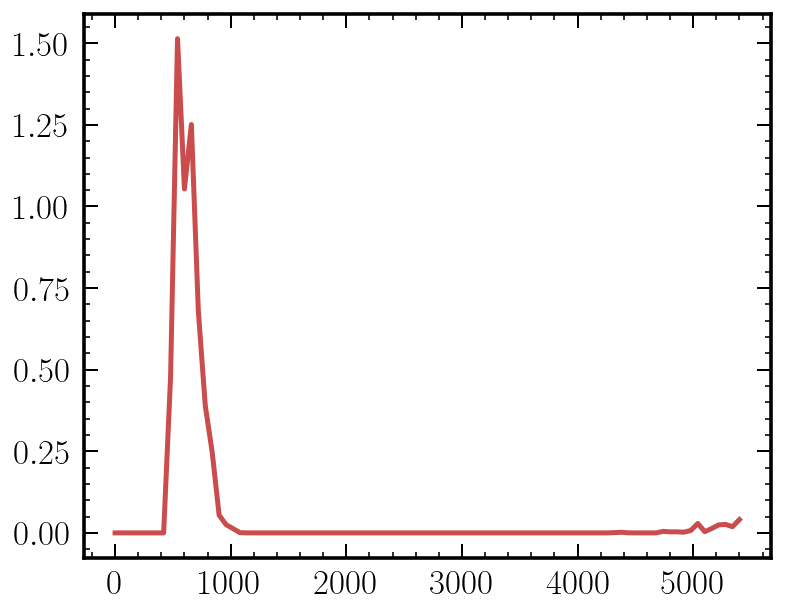

In [7]:
plt.plot(output['T'].dt.seconds.data, output['rain water mixing ratio'][:, 0, :].sum(dim= 'X').values*1e3)

In [8]:
output['rain water mixing ratio'][:, 0, :].sum(dim= 'X').values.sum()*1e3

5.887212697416544

In [9]:
output_2= xarray.open_dataset(sav_file_path + "_n1_10_r1_0.1_benchmark.nc")

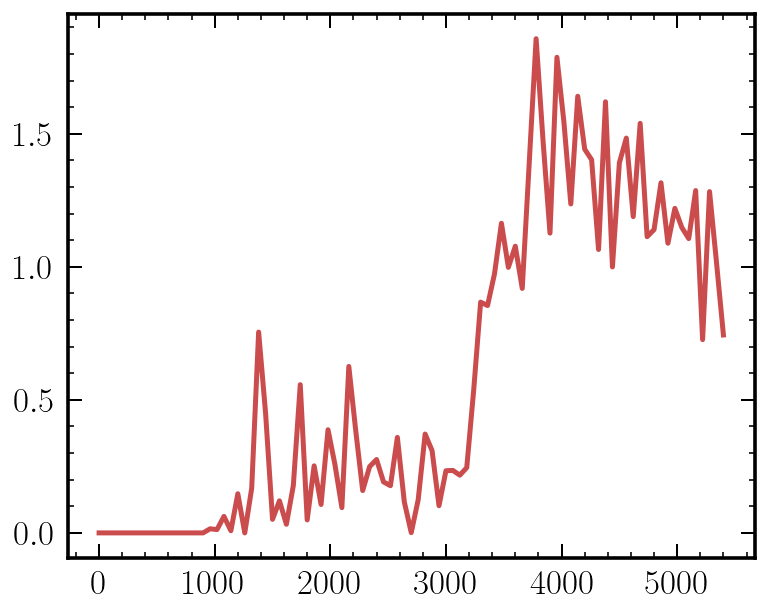

In [10]:
plt.plot(output_2['T'].dt.seconds.data, output_2['rain water mixing ratio'][:, :, 0].sum(dim= 'X').values*1e3)

In [11]:
output_2['rain water mixing ratio'][:, :, 0].sum(dim= 'X').values.sum()*1e3

52.85119637846947

## Ensemble run

In [2]:
common_params= {
    "n_sd_per_mode": (32,),
    "aerosol_modes_by_kappa": {
        0.54: Lognormal(
        norm_factor=10 / si.cm ** 3,
        m_mode=1E2 * si.nm,
        s_geom=1.4,
        ),},
    "z_part": ((0., 1), (0., 0.25)),
    "x_part": ((0., 1), (0., 0.25)),
    "grid": (25, 25),
    "size": (1500 * si.metres, 1500 * si.metres),
    "simulation_time": 5400 * si.second,
    "dt": 5*si.second,
    "spin_up_time": 1800 * si.second,
}

In [31]:
np.random.seed(87)
n_runs= 10
seed_flag= True

for r_id in tqdm(range(n_runs)):
    if seed_flag:
        settings = Settings(Formulae(seed= np.random.randint(1000)), **common_params, r_seed= 5*si.um, m_param= 1e8, kappa_seed= 0.85)
        storage = Storage()
        simulation = Simulation(settings, storage, SpinUp= None)
        simulation.reinit()

        seed_step_arr= [50, 100, 600]
        seed_output_step_arr= settings.output_steps[[np.argmin(abs(settings.output_steps - ss)) for ss in seed_step_arr]]
        simulation.stepwise_sd_update(seed_step= seed_output_step_arr, spup_flag= True)
        exporter = NetCDFExporter(storage, settings, simulation, sav_file_path + 'seeded_ensemble_%d'%r_id + '_n1_10_r1_0.1_rsd_5_logmsd_8_zseed_0.25_xseed_0.25_tseed_50_100_600.nc')
        exporter.run(controller=DummyController())
    else:
        settings_bench = Settings(Formulae(seed= np.random.randint(1000)), **common_params)
        storage_bench = Storage()
        simulation_bench = Simulation(settings_bench, storage_bench, SpinUp= None)
        simulation_bench.reinit()

        #simulation_bench.particulator.run(steps= settings_bench.n_spin_up)
        #simulation_bench.particulator.n_steps = 0
        #simulation_bench.run()
        simulation_bench.stepwise_sd_update(spup_flag= True)
        exporter_bench = NetCDFExporter(storage_bench, settings_bench, simulation_bench, sav_file_path + 'seeded_ensemble_%d'%r_id + '_n1_10_r1_0.1_benchmark.nc')
        exporter_bench.run(controller=DummyController())

  0%|          | 0/10 [00:00<?, ?it/s]/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:45: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
  0%|          | 0/10 [00:02<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/hyfives-lamont/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/l0/hrygmj0j75scyr71140zzkzm0000gn/T/ipykernel_8842/3781029221.py", line 14, in <module>
    simulation.stepwise_sd_update(seed_step= seed_output_step_arr, spup_flag= True)
  File "/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/examples/PySDM_examples/Buch_et_al_2024/case_files/simulation_sd_update_2d.py", line 247, in stepwise_sd_update
    self.particulator.run(steps=self.settings.n_spin_up)
  File "/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/particulator.py", line 49, in run
    dynamic()
  File "/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/dynamics/eulerian_advection.py", line 23, in __call__
  File "/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/examples/PySDM_examples/Szumowski_et_al_1998/mpdata_2d.py", line 104, in _

In [29]:
# load the output files as xarray datasets with ensemble number as a new dimension
ds= xarray.open_mfdataset(sav_file_path + 'seeded_ensemble_*_n1_10_r1_0.1_rsd_5_logmsd_13_zseed_0.25_xseed_0.25_tseed_50_100_200_400_600.nc', combine='nested', concat_dim='ensemble')
ds= ds.transpose("ensemble", "T", "Z", "X", "Particles Wet Size Spectrum_bin_left_edges", "Particles Dry Size Spectrum_bin_left_edges", 'radius binned number averaged terminal velocity_bin_left_edges')
ds_bench= xarray.open_mfdataset(sav_file_path + 'seeded_ensemble_*_n1_10_r1_0.1_benchmark.nc', combine='nested', concat_dim='ensemble')
ds_bench= ds_bench.transpose("ensemble", "T", "Z", "X", "Particles Wet Size Spectrum_bin_left_edges", "Particles Dry Size Spectrum_bin_left_edges", 'radius binned number averaged terminal velocity_bin_left_edges')

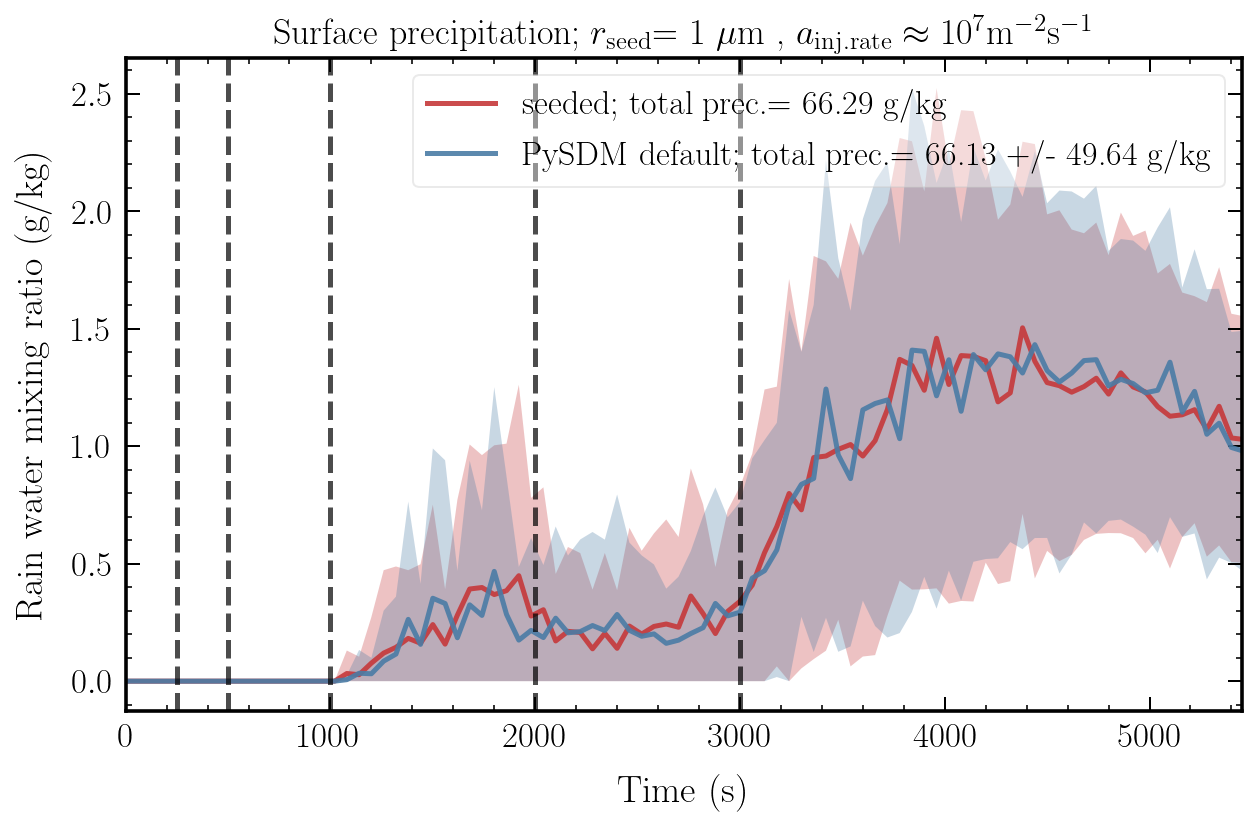

In [30]:
fig, ax= plt.subplots(1, 1, figsize= (10, 6))
plt.plot(ds['T'].dt.seconds.data, ds['rain water mixing ratio'].mean(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3, label= 'seeded; total prec.= %.2f g/kg'%(ds['rain water mixing ratio'].mean(dim= 'ensemble')[:, 0, :].sum(dim= ('T','X'))*1e3)) #.sum(axis= (1, 2))
seeded_low_sig= (ds['rain water mixing ratio'].mean(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3 - ds['rain water mixing ratio'].std(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3).to_numpy()
seeded_low_sig[seeded_low_sig < 0]= 0
plt.fill_between(ds['T'].dt.seconds.data, seeded_low_sig, \
                                       ds['rain water mixing ratio'].mean(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3 + ds['rain water mixing ratio'].std(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3, alpha= 0.3)
bench_mean= ds_bench['rain water mixing ratio'].mean(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3
bench_std= ds_bench['rain water mixing ratio'].std(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3
bench_low_sig= (bench_mean - ds_bench['rain water mixing ratio'].std(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3).to_numpy()
bench_low_sig[bench_low_sig < 0]= 0
plt.plot(ds_bench['T'].dt.seconds.data, bench_mean, label= 'PySDM default; total prec.= %.2f '%(bench_mean.sum(dim= ('T'))) + ' +/- %.2f g/kg'%(bench_std.sum(dim= ('T')))) #.sum(axis= (1, 2))
plt.fill_between(ds_bench['T'].dt.seconds.data, bench_low_sig, \
                                                    bench_mean + ds_bench['rain water mixing ratio'].std(dim= 'ensemble')[:, 0, :].sum(dim= 'X')*1e3, alpha= 0.3)
plt.xlim(0, 5450)
plt.xlabel("Time (s)")
plt.ylabel("Rain water mixing ratio (g/kg)")
# plot three vertical lines at seeding steps
seed_step_arr= [50, 100, 200, 400, 600]
for ss in seed_step_arr:
    ax.axvline(ss*5, color= 'k', alpha= 0.7, linestyle= '--')
ax.legend(frameon= True, loc= 'upper right')
plt.title(r"Surface precipitation; $r_{\rm seed}$= 1 $\mu {\rm m}$ , $a_{\rm inj. rate} \approx 10^7 {\rm} {\rm m}^{-2} {\rm s}^{-1}$", fontsize= 18);
#plt.savefig(sav_plt_path + 'surface_rwr_n1_10_r1_0.1_rsd_1_logmsd_11_zseed_0.25_xseed_0.25_tseed_50_100_200_400_600.pdf', bbox_inches='tight', dpi= 300);

## Plotting

In [6]:
output= xarray.open_dataset(sav_file_path + "seeded_benchmark_x_z_sample_n1_50_r1_0.1.nc")
output= output.transpose("T", "Z", "X", "Particles Wet Size Spectrum_bin_left_edges", "Particles Dry Size Spectrum_bin_left_edges", 'radius binned number averaged terminal velocity_bin_left_edges')
output_2= xarray.open_dataset(sav_file_path + "seeded_sample_n1_50_r1_0.1_rsd_10_logmsd_11_zseed_0.25_xseed_0.25_tseed_50_100_200_400_600_alt.nc")
output_2= output_2.transpose("T", "Z", "X", "Particles Wet Size Spectrum_bin_left_edges", "Particles Dry Size Spectrum_bin_left_edges", 'radius binned number averaged terminal velocity_bin_left_edges')
#output= xarray.open_dataset(sav_file_path + "benchmark_case.nc")

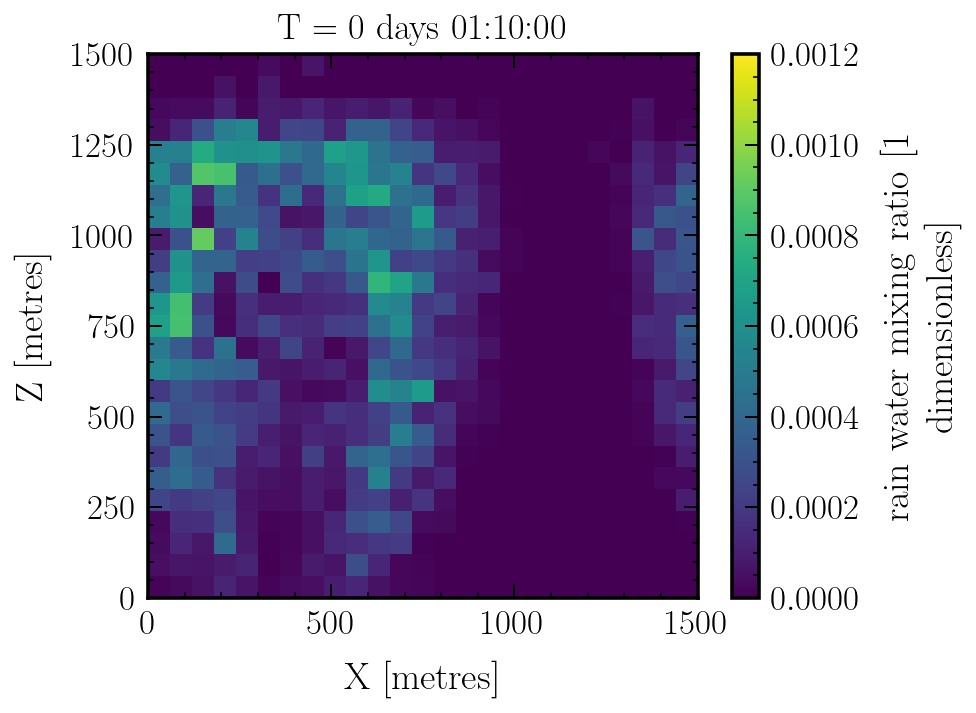

In [7]:
output['rain water mixing ratio'][70].plot(vmin= 0, vmax= 0.0012)

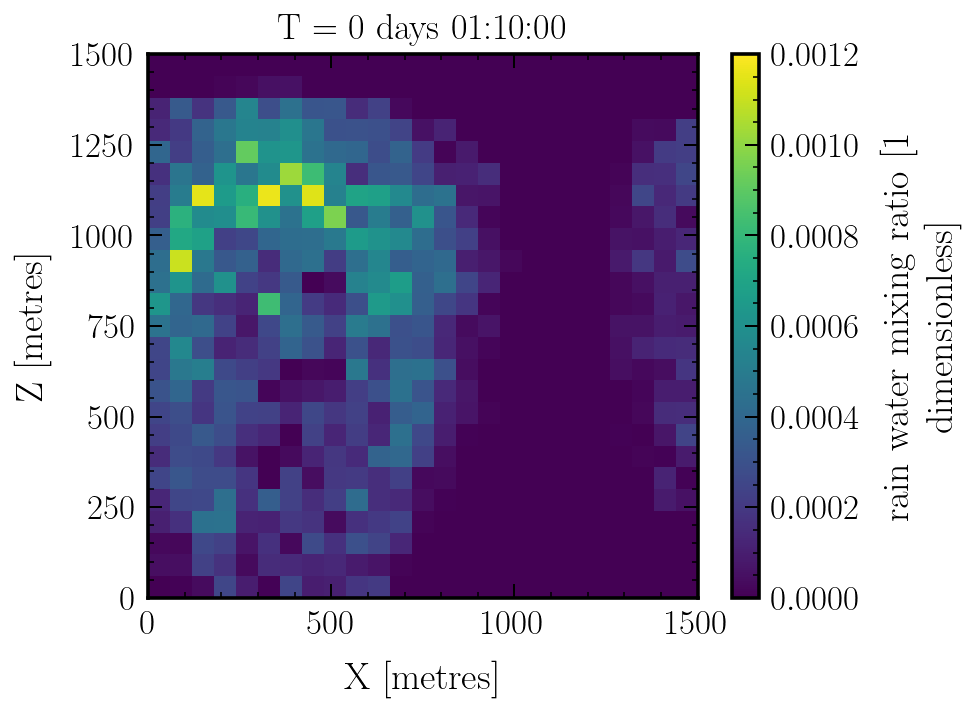

In [8]:
output_2['rain water mixing ratio'][70].plot(vmin= 0, vmax= 0.0012)

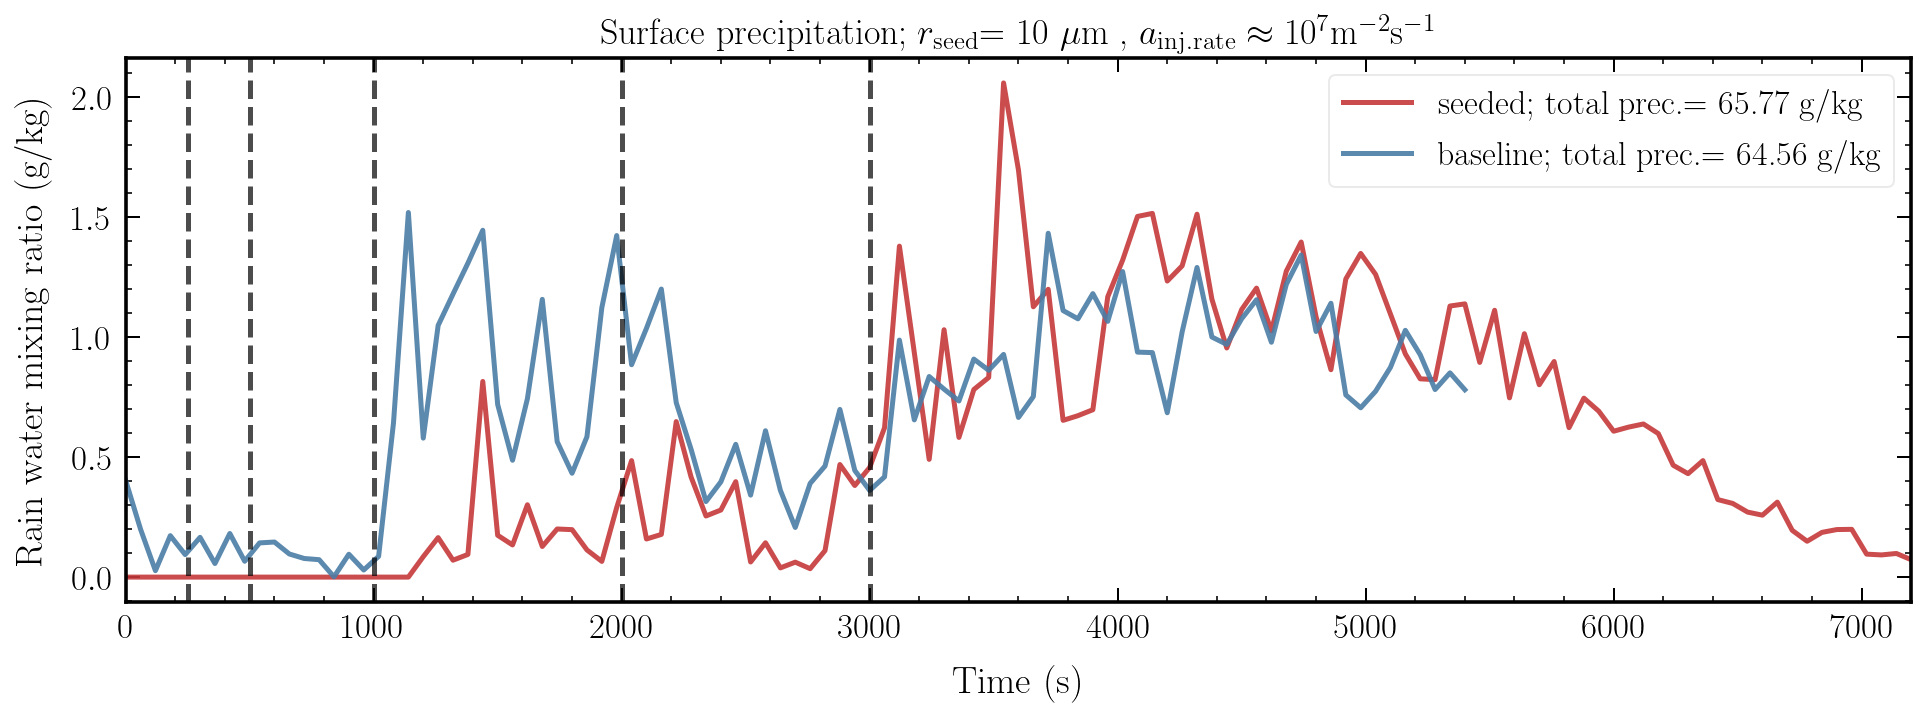

In [10]:
fig, ax= plt.subplots(1, 1, figsize= (16, 5))
plt.plot(output_2['T'].dt.seconds.data, output_2['rain water mixing ratio'][:, 0, :].sum(dim= 'X')*1e3, label= 'seeded; total prec.= %.2f g/kg'%(output_2['rain water mixing ratio'][:, 0, :].sum(dim= ('T','X'))*1e3)) #.sum(axis= (1, 2))
plt.plot(output['T'].dt.seconds.data, output['rain water mixing ratio'][:, 0, :].sum(dim= 'X')*1e3, label= 'baseline; total prec.= %.2f g/kg'%(output['rain water mixing ratio'][:, 0, :].sum(dim= ('T','X'))*1e3)) #.sum(axis= (1, 2))
plt.xlim(0, 7200)
plt.xlabel("Time (s)")
plt.ylabel("Rain water mixing ratio (g/kg)")
# plot three vertical lines at seeding steps
seed_step_arr= [50, 100, 200, 400, 600]
for ss in seed_step_arr:
    ax.axvline(ss*5, color= 'k', alpha= 0.7, linestyle= '--')
ax.legend(frameon= True, loc= 'upper right')
plt.title(r"Surface precipitation; $r_{\rm seed}$= 10 $\mu {\rm m}$ , $a_{\rm inj. rate} \approx 10^7 {\rm} {\rm m}^{-2} {\rm s}^{-1}$", fontsize= 18);
#plt.savefig(sav_plt_path + 'surface_rwr_n1_50_r1_0.1_rsd_10_logmsd_11_zseed_0.25_xseed_0.25_tseed_50_100_200_400_600.pdf', bbox_inches='tight', dpi= 300);

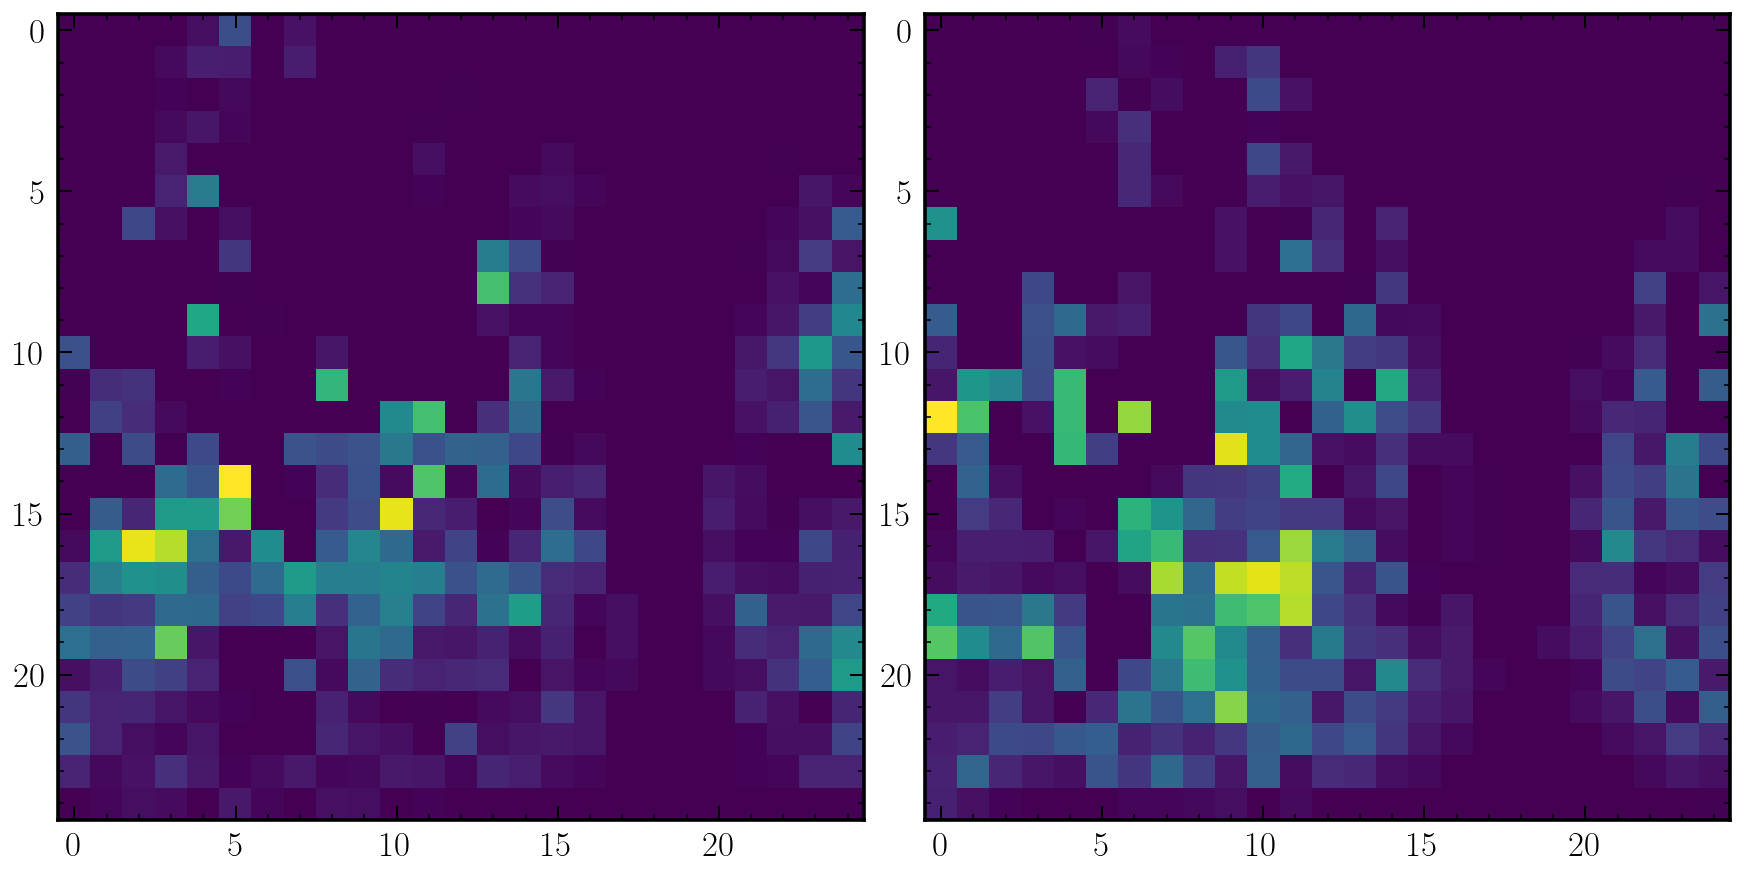

In [39]:
fig, ax= plt.subplots(1, 2, figsize= (12, 6), constrained_layout= True)
ax[0].imshow(output['rain water mixing ratio'][70])
ax[1].imshow(output_2['rain water mixing ratio'][70])
# plt.plot(output_2['T'].dt.seconds.data, output_2['rain water mixing ratio'][:, 0, :].sum(dim= 'X'), label= 'seeded; total prec.= %.3f g/g'%output_2['rain water mixing ratio'][:, 0, :].sum(dim= ('T','X'))) #.sum(axis= (1, 2))
# plt.xlabel("Time (s)")
# plt.ylabel("Rain water mixing ratio (g/g)")
# # plot three vertical lines at seeding steps
# seed_step_arr= [50, 100, 150, 200, 600, 700]
# for ss in seed_step_arr:
#     ax.axvline(ss*5, color= 'k', alpha= 0.7, linestyle= '--')
# ax.legend(frameon= True)
# plt.title(r"Surface precipitation; $r_{\rm seed}$= 1 $\mu {\rm m}$ , $a_{\rm inj. rate} \approx 10^7 {\rm} {\rm m}^{-2} {\rm s}^{-1}$", fontsize= 18);

## Animations

/var/folders/s1/9vttm2bd2074z9_lf1r86fkm0000gn/T/ipykernel_15171/3298348711.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))


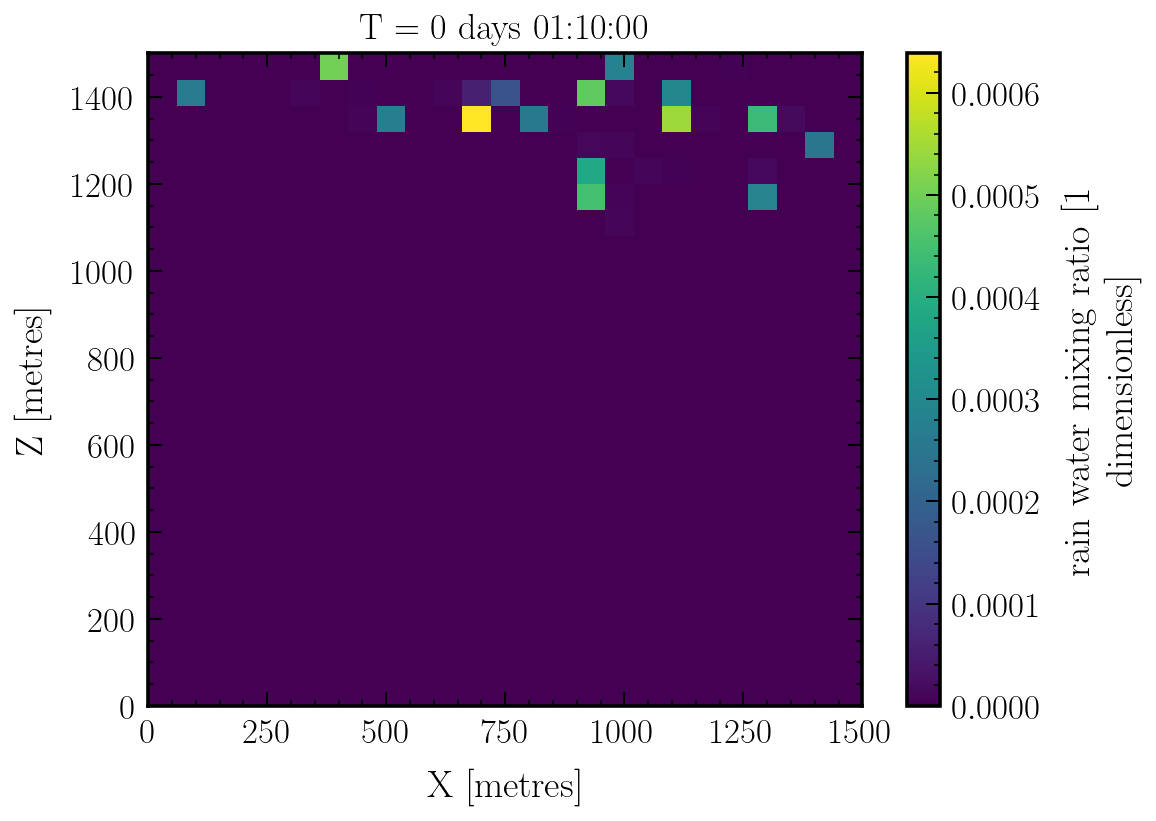

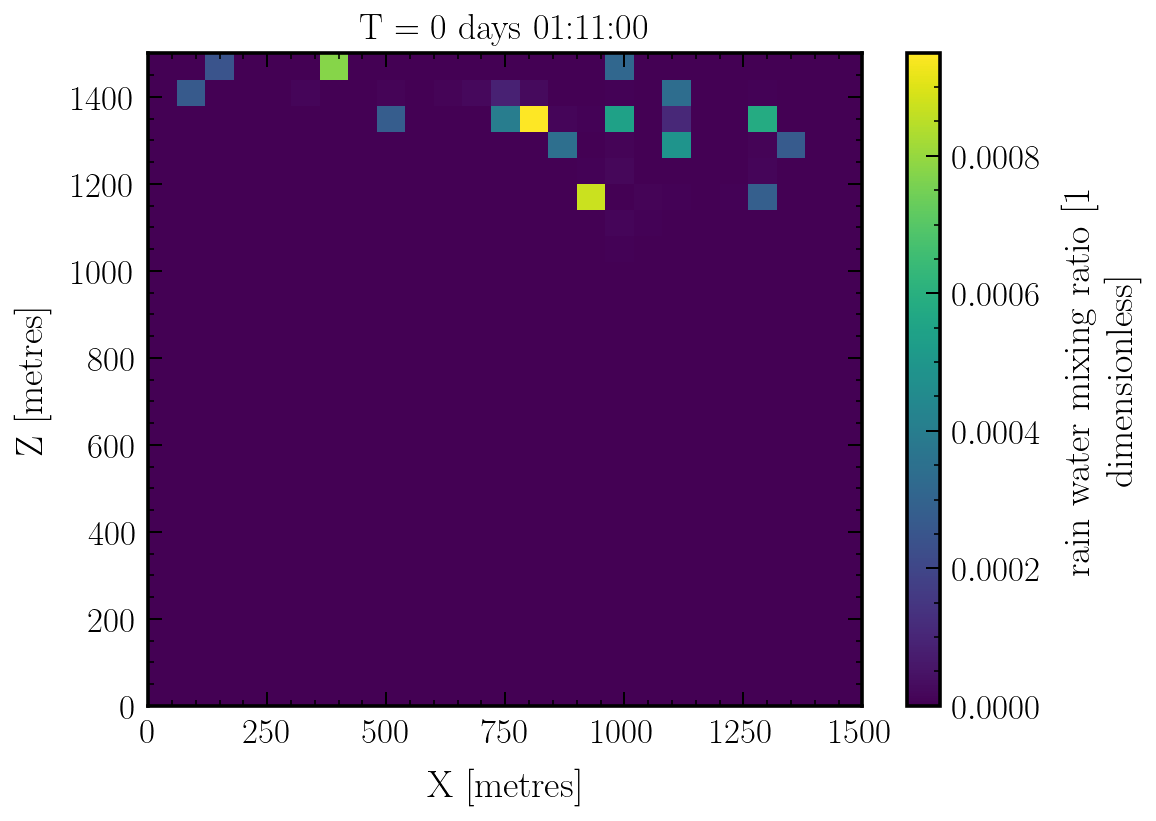

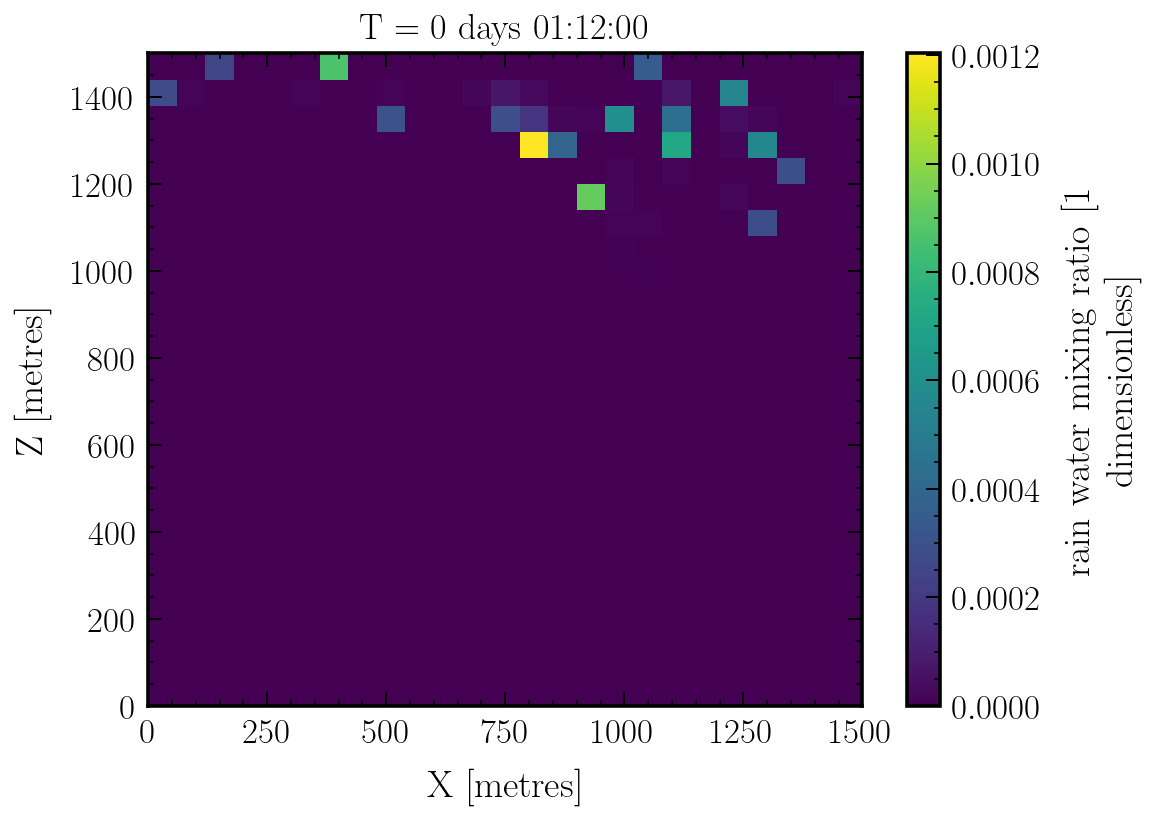

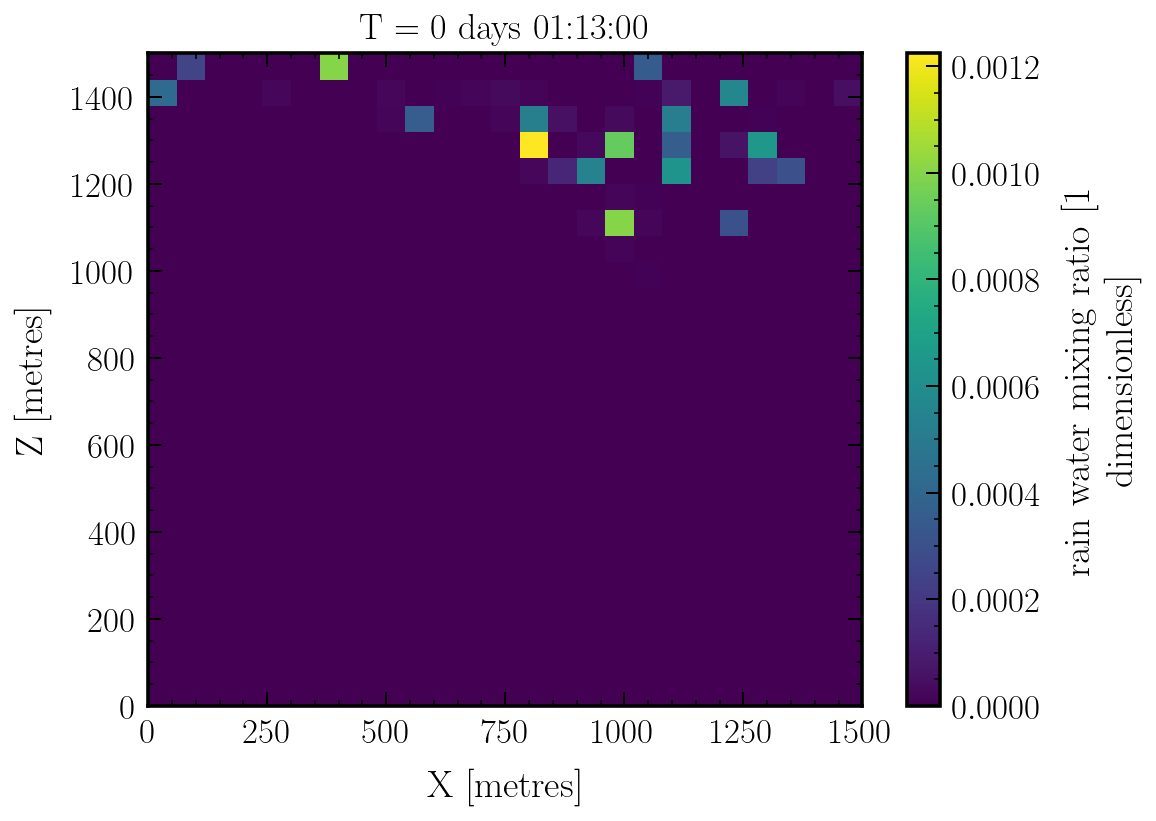

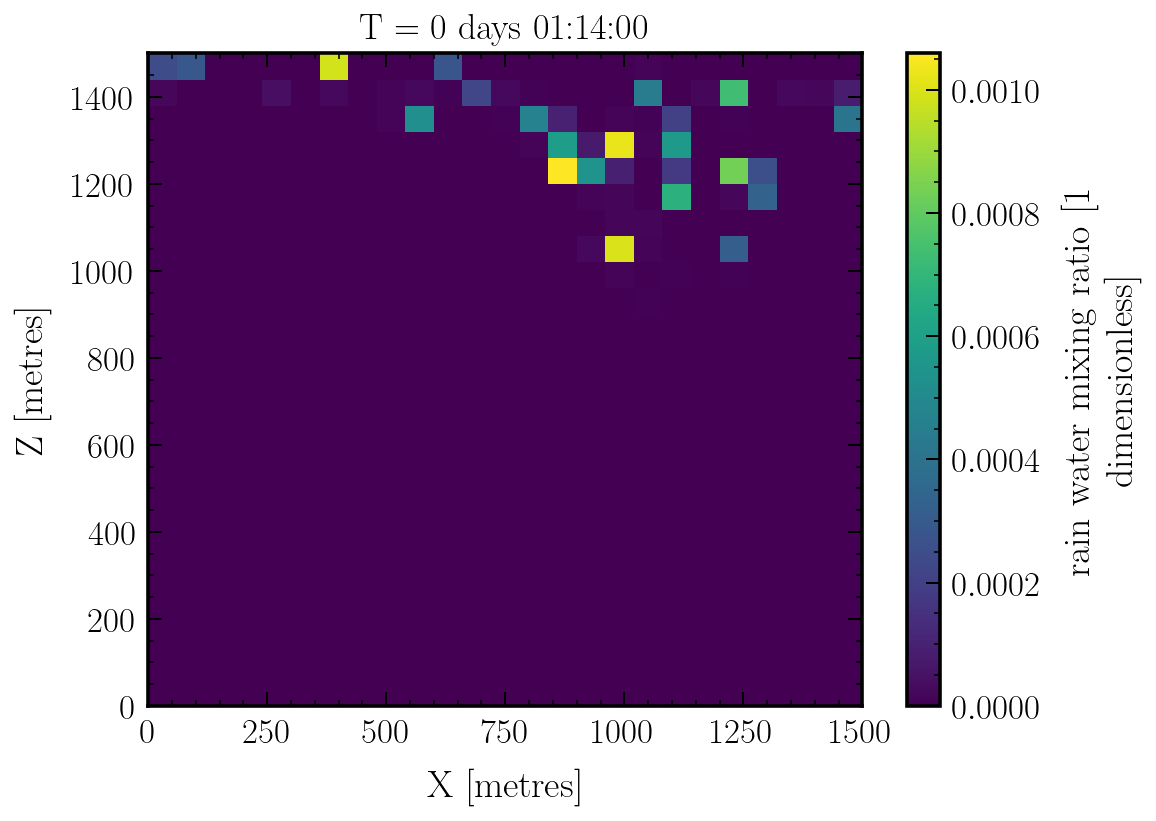

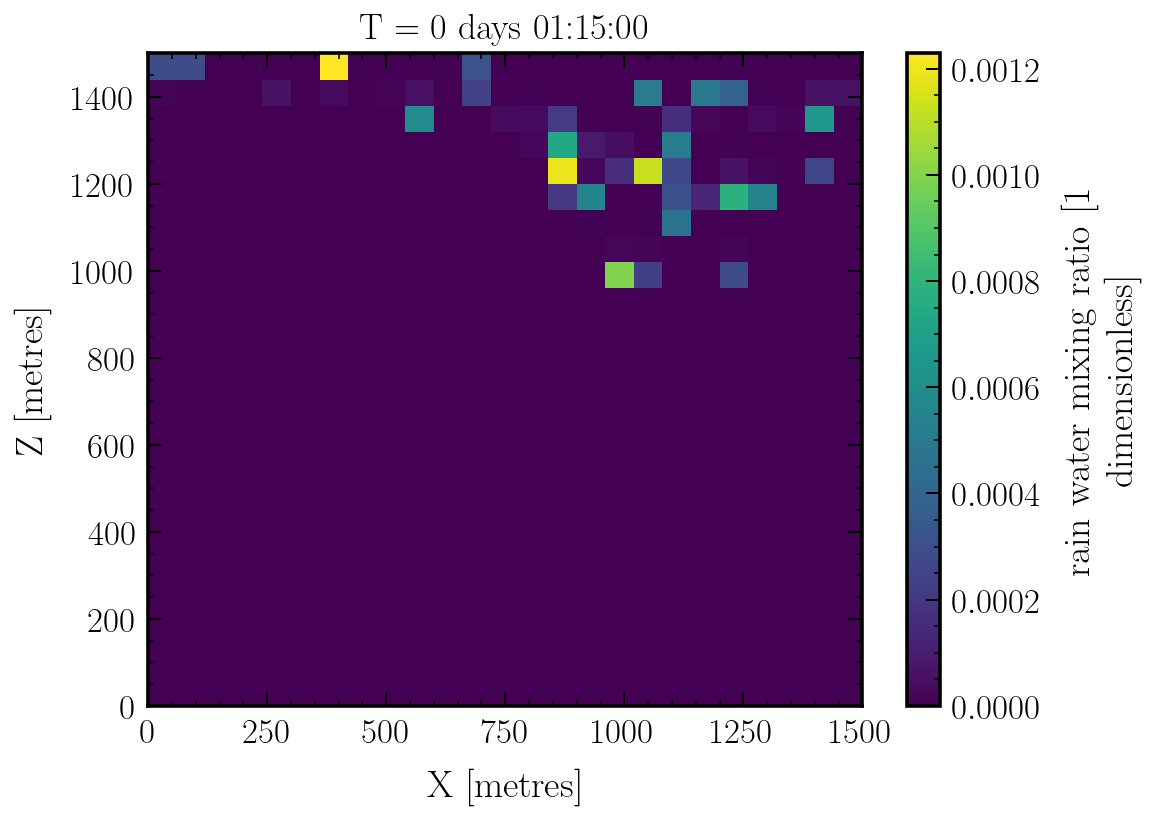

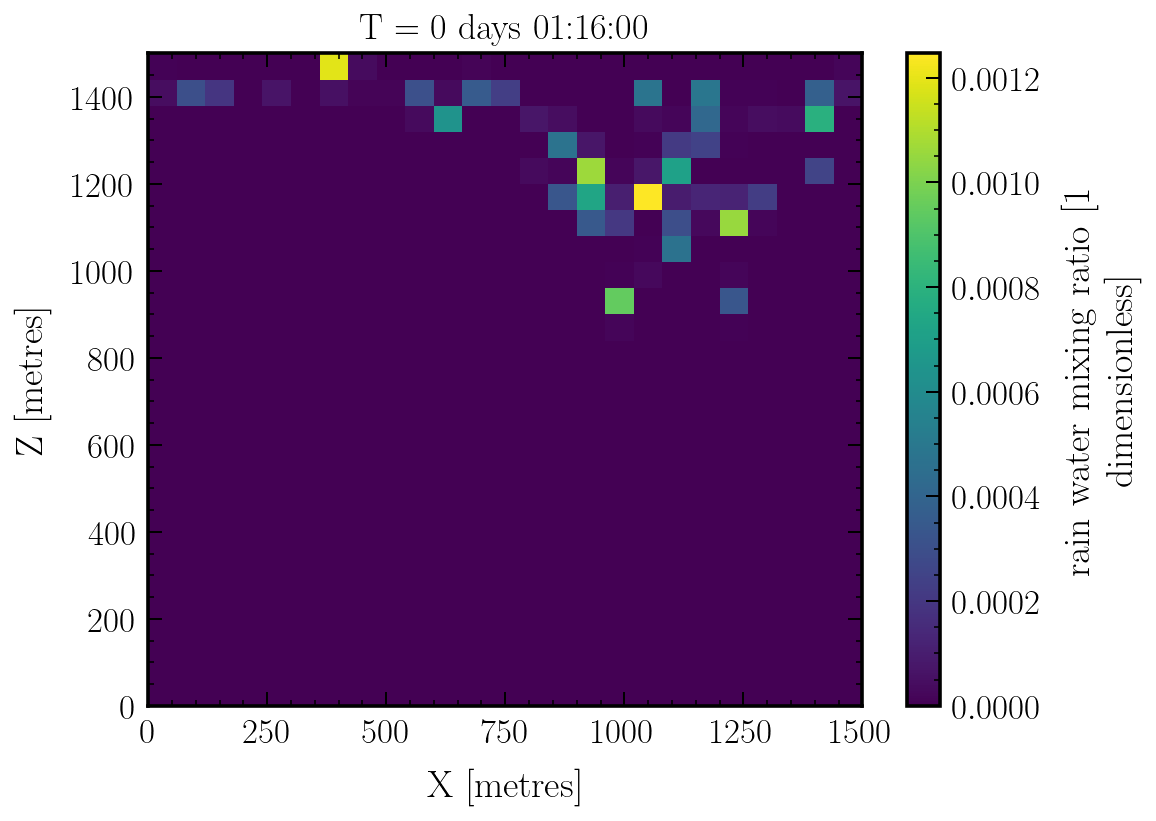

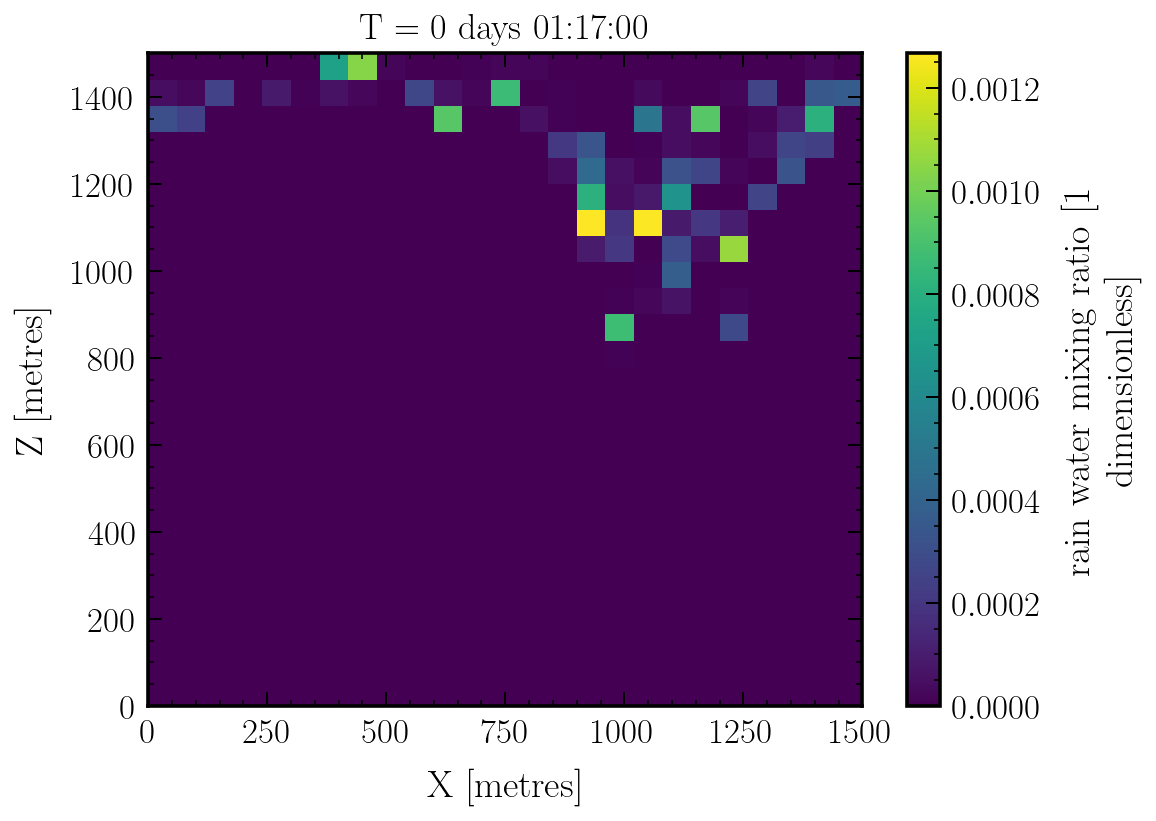

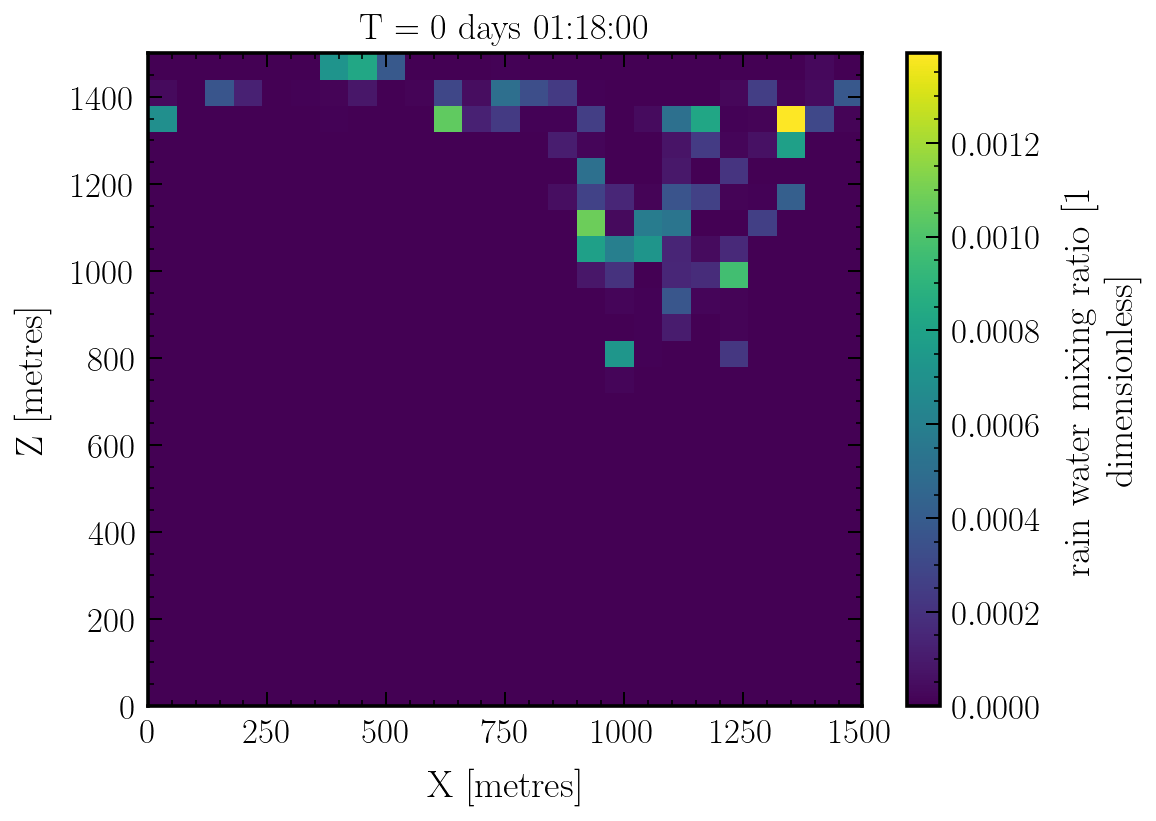

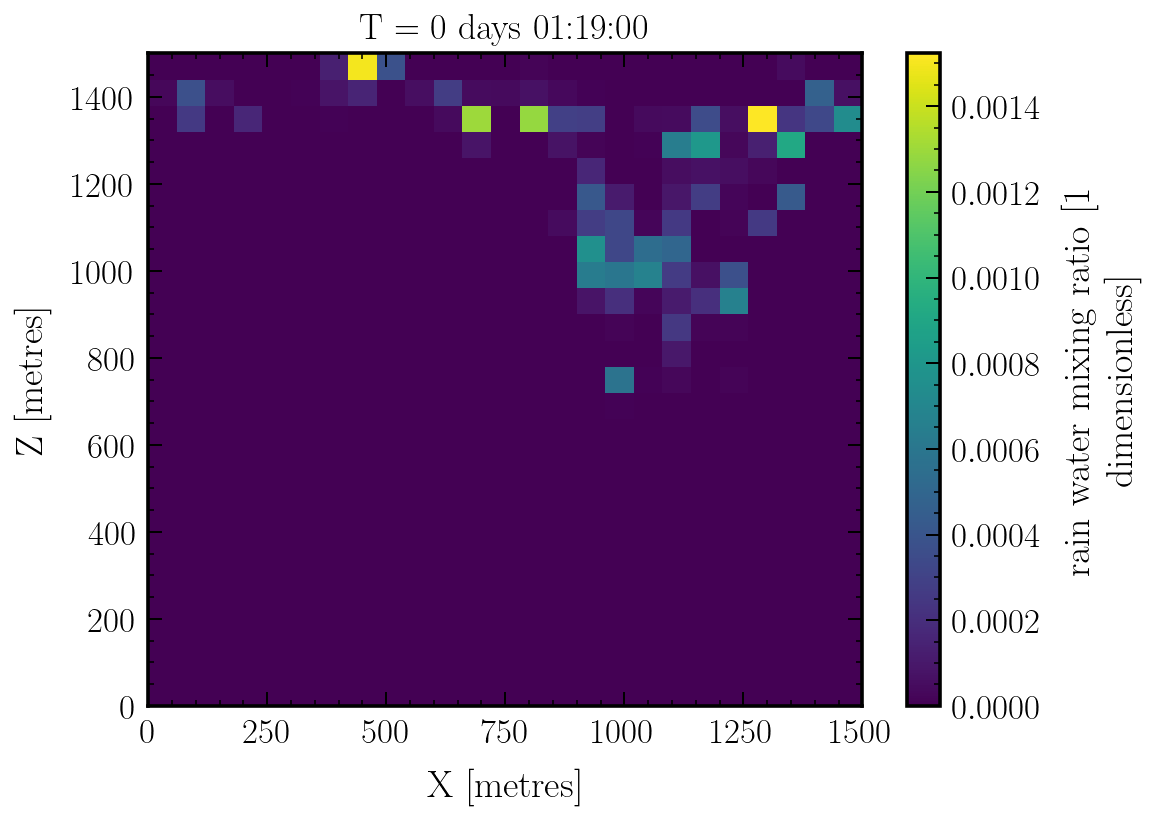

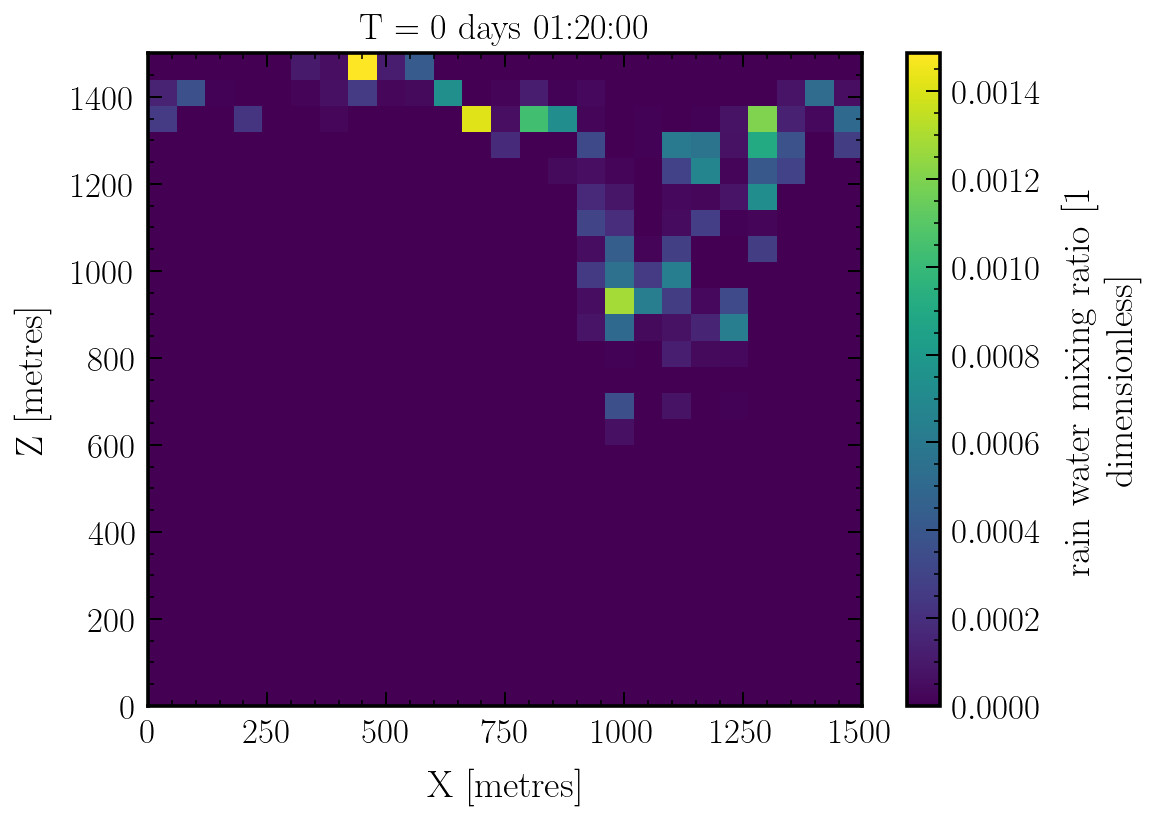

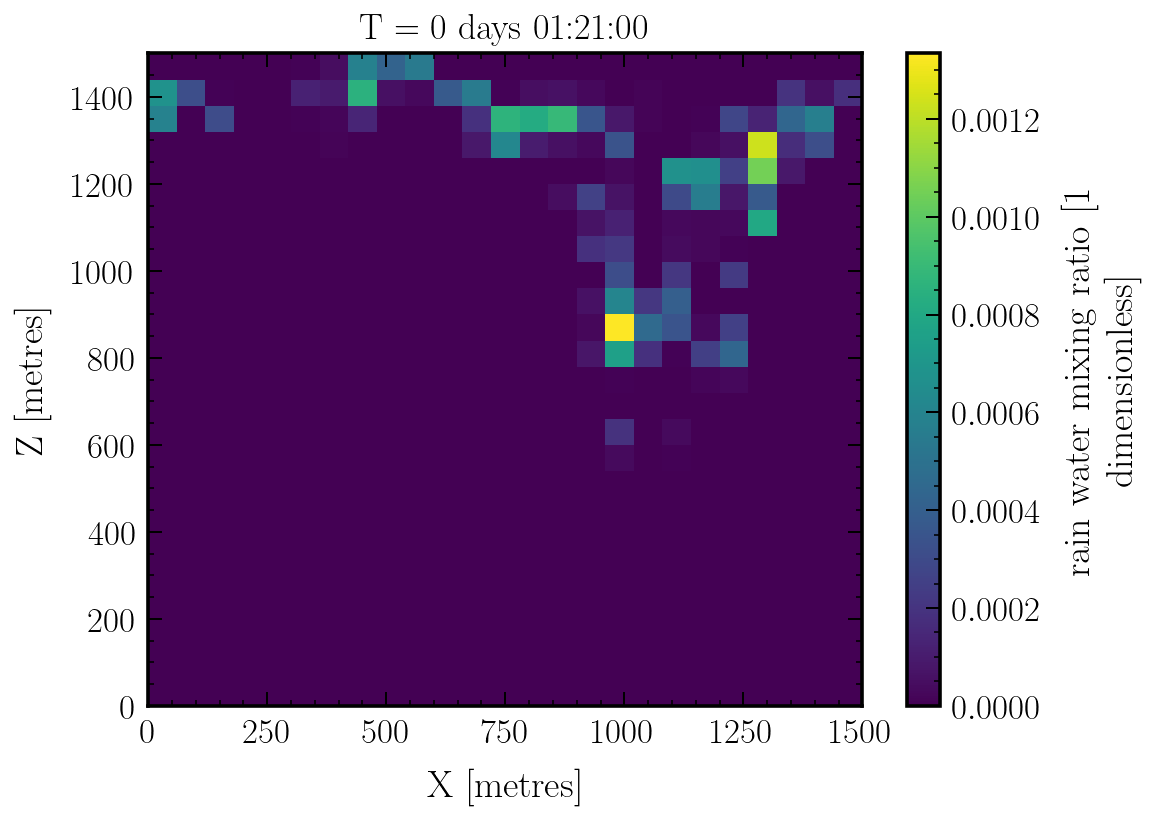

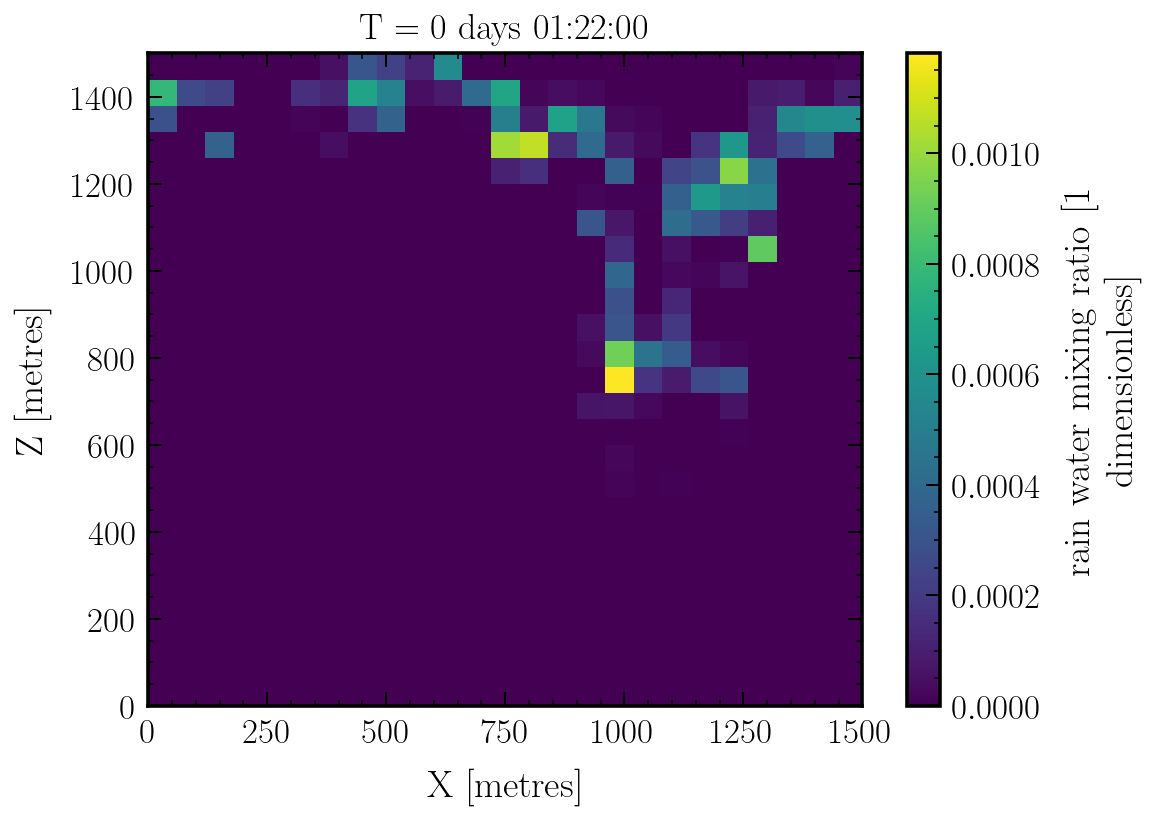

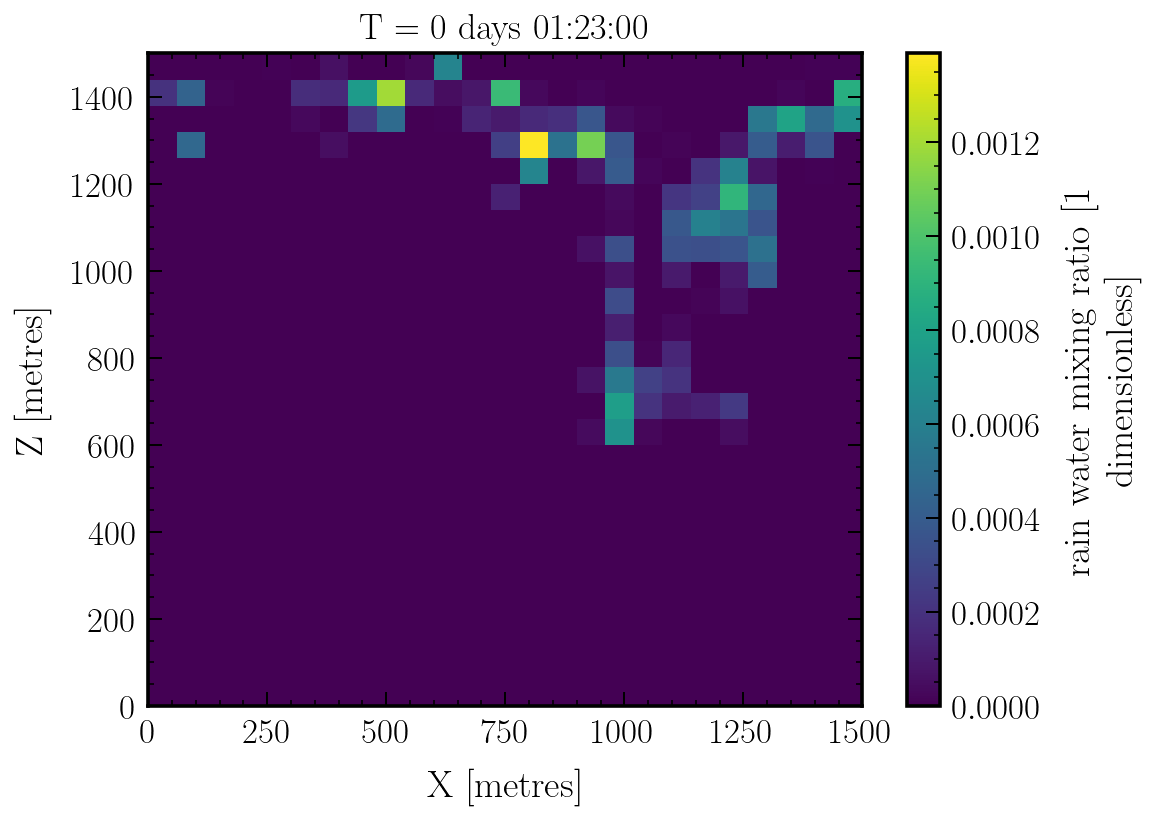

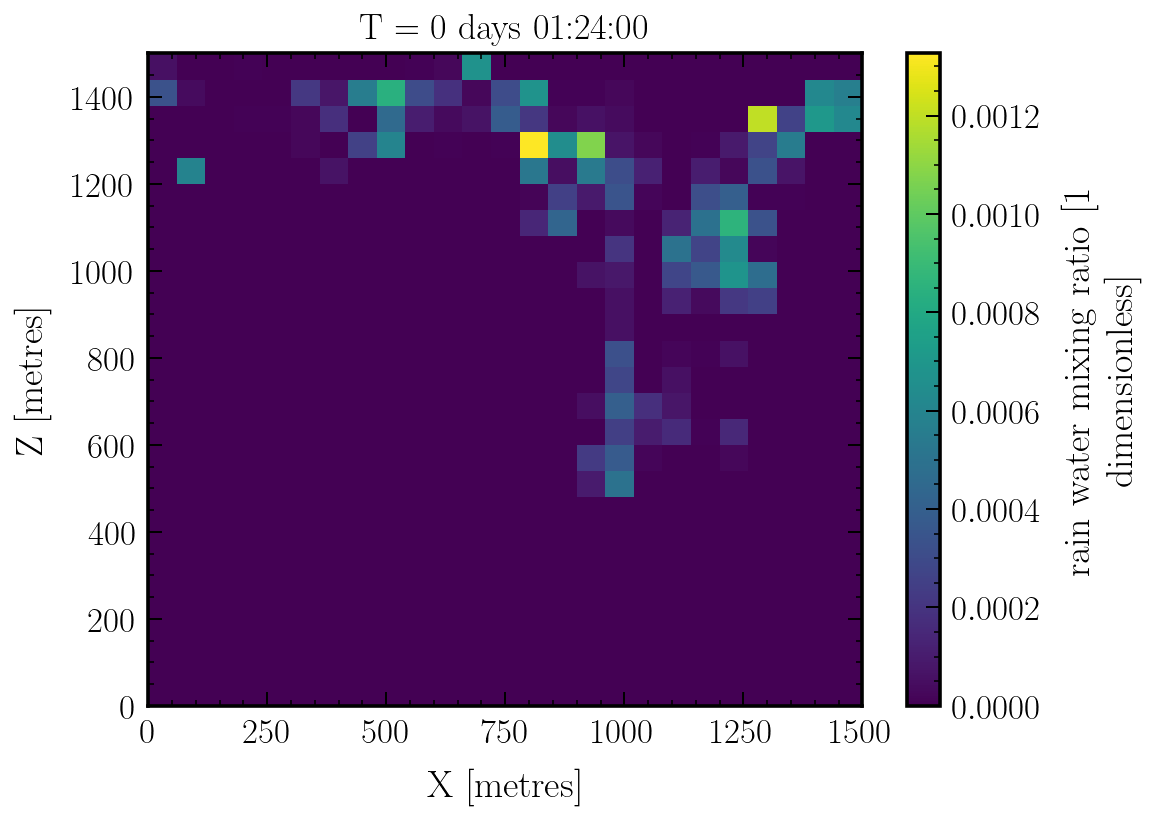

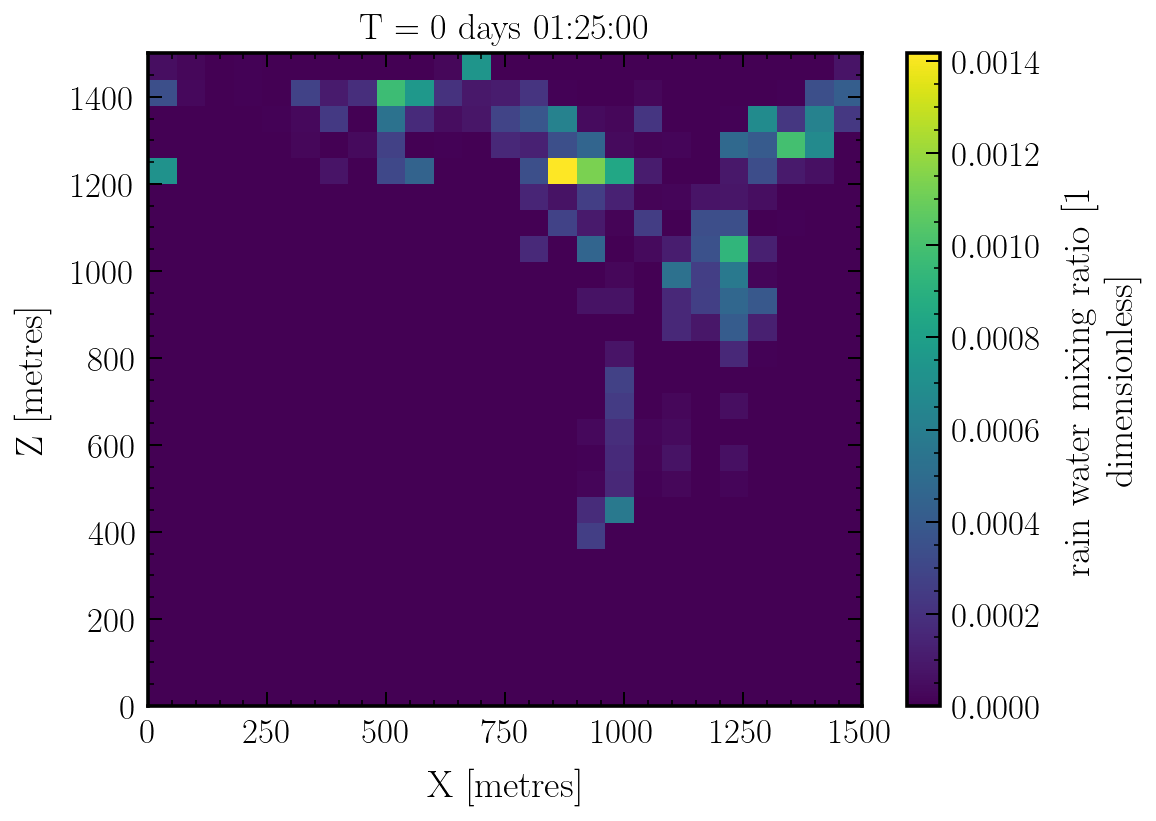

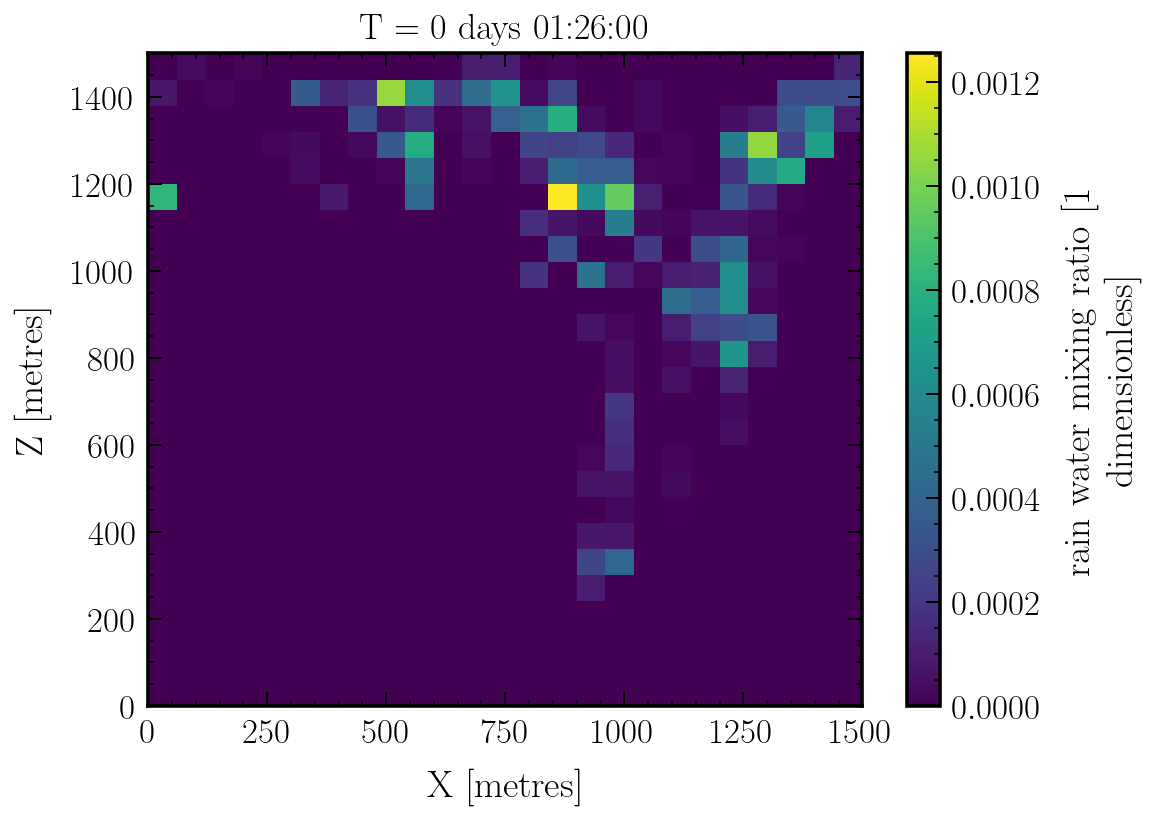

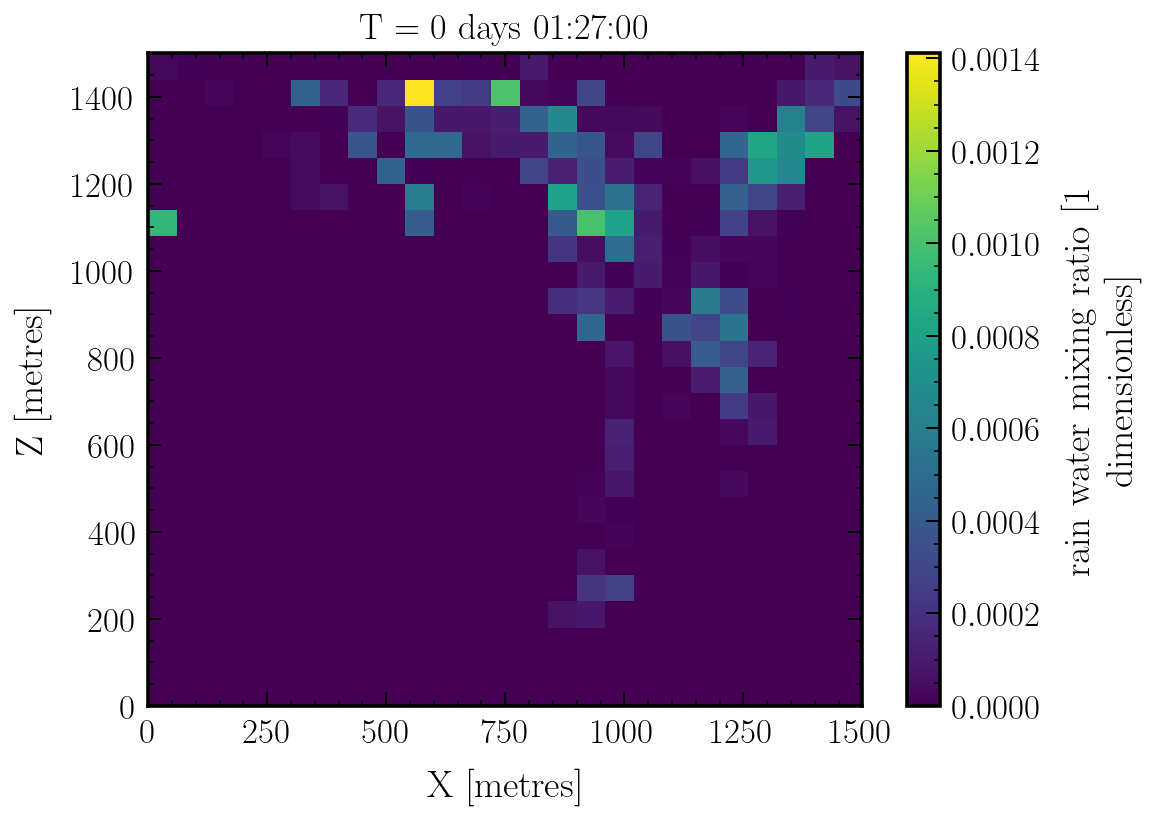

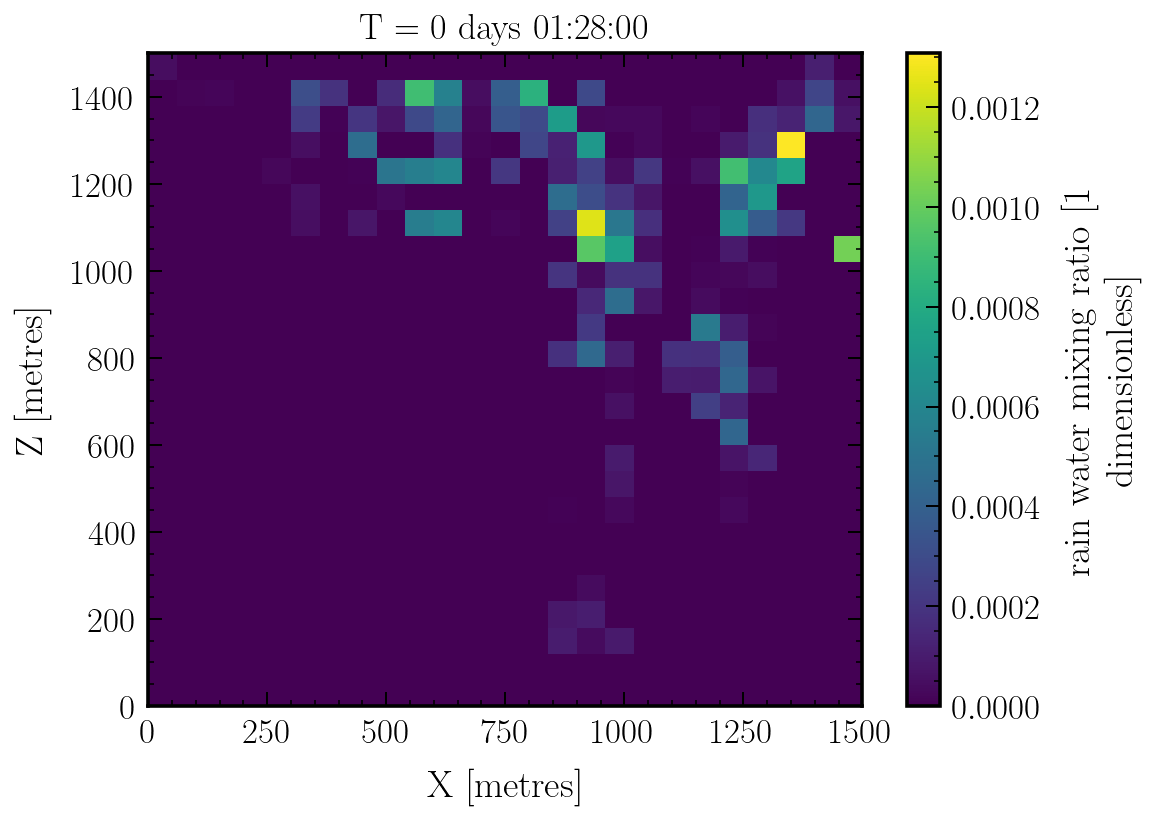

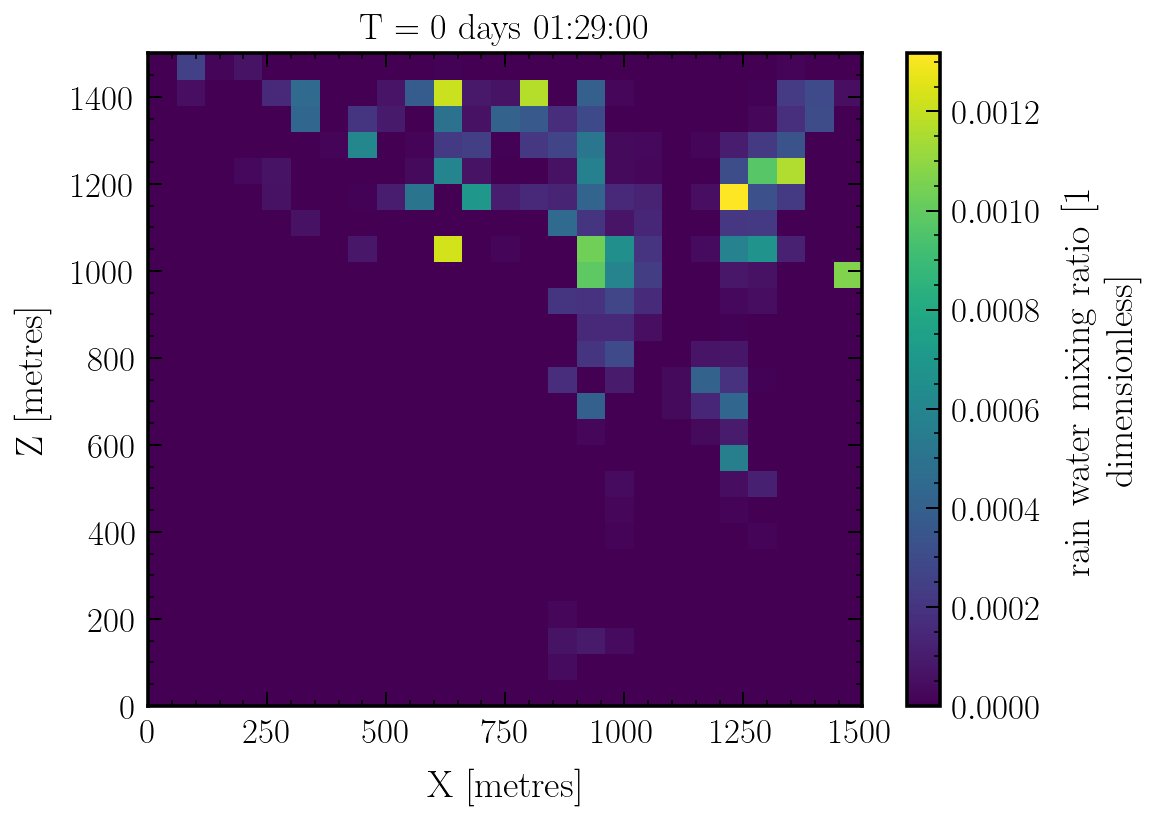

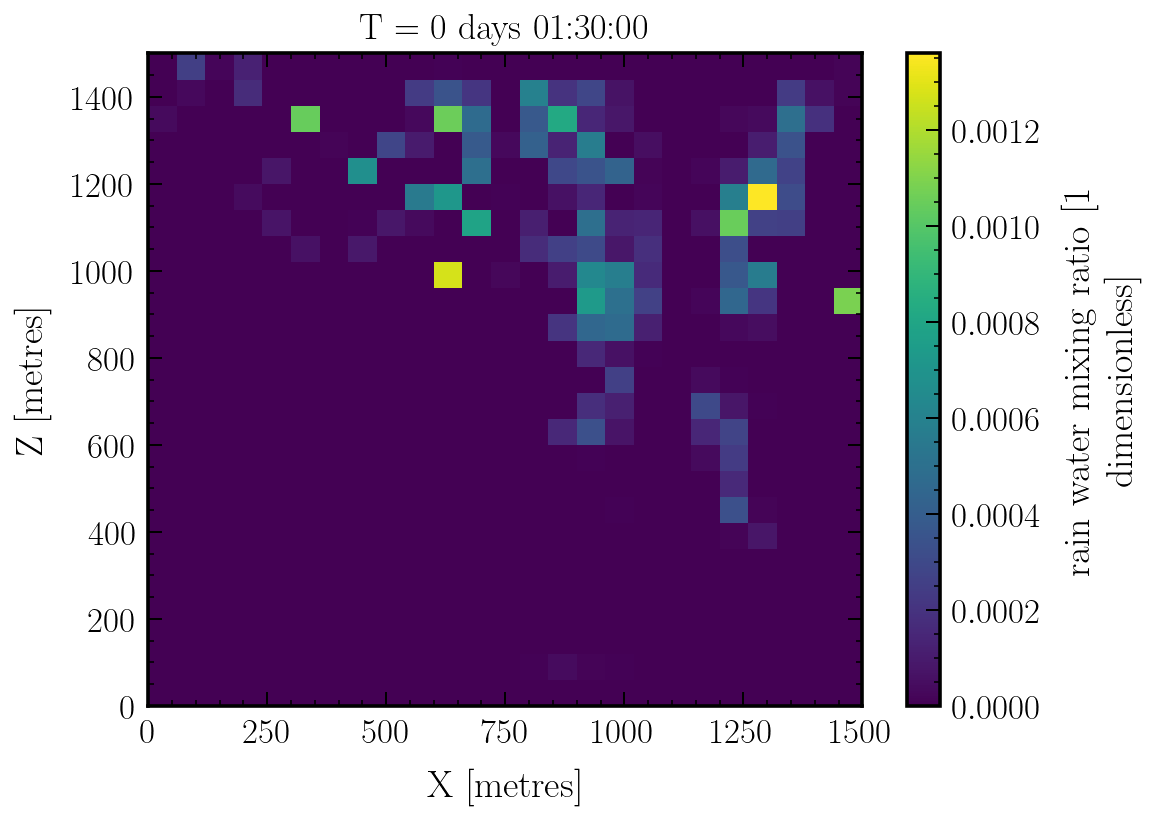

In [18]:
for i in range(70, 91, 1):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    output['rain water mixing ratio'][i].plot(ax= ax)
    #plt.savefig("./output_%d.jpg"%i, dpi= 300, bbox_inches= "tight");

In [19]:
from PIL import Image

# List of image file paths
image_files = ["./output_%d.jpg"%i for i in range(70, 91, 1)]

# Open the images and store them in a list
images = [Image.open(img_file) for img_file in image_files]

# Create a GIF from the images
output_gif_path = "../../plots/rain_2D_no_seed_gif.gif"
images[0].save(
    output_gif_path, 
    save_all=True, 
    append_images=images[1:],  # Appends all images in the list after the first one
    optimize=False, 
    duration=500,  # Duration each image shows in the GIF in milliseconds
    loop=0  # Loop forever
)

print(f"GIF saved at {output_gif_path}")

GIF saved at ../../plots/rain_2D_no_seed_gif.gif


## Experiments

In [3]:
from utils import spatial_sampling_2d as spatial_sampling
from PySDM.impl.mesh import Mesh
from PySDM.backends import CPU
from copy import deepcopy

In [4]:
mesh= Mesh(settings.grid, settings.size)

In [11]:
positions = spatial_sampling.Pseudorandom().sample(backend= CPU(), grid= settings.grid, n_sd= 32*25*25)

In [13]:
cellid, cellog, poscell= mesh.cellular_attributes(positions)

In [17]:
cellog_b= deepcopy(cellog)

In [24]:
np.append(cellog, cellog_b, axis= 1).shape

(2, 40000)